
# **CONVOLUTIONAL AUTOENCODER**
## ACML Assignemnt 2 Part 1 : RECONSTRUCTION

1. Load Data
2. Split : Val, test, train 
3. Run model 
4. Latent space dimension
W= 8, P=S=1, K=3, C=16 --> 1024
5. Try different architectures: ??



In [118]:
import os
import torch 
import numpy as np

#from utils import plot_images
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [119]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
BATCH_SIZE = 32

In [120]:
transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [121]:
train = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

data_list = list()
data_list.append(train)
data_list.append(test)
total = torch.utils.data.ConcatDataset(data_list)

Files already downloaded and verified
Files already downloaded and verified


In [122]:
train_set, val_set = torch.utils.data.random_split(total, [48000, 12000])
val_set, test_set = torch.utils.data.random_split(val_set, [6000, 6000])
print(f'training set size {len(train_set)}')
print(f'testing set size {len(test_set)}')
print(f'validation set size {len(val_set)}')

training set size 48000
testing set size 6000
validation set size 6000


In [123]:
trainloader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
testloader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)
valloader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=True)

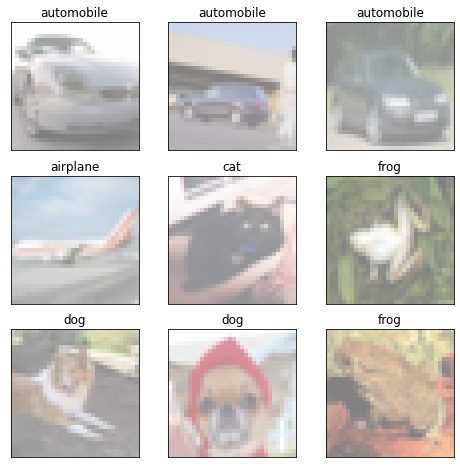

In [124]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [125]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'Conv_CIFAR10_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, name)

In [126]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.enc2 = nn.Conv2d(8, 12, 3, stride=1, padding=1)
        self.enc3 = nn.Conv2d(12, 16, 3, stride=1, padding=1)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(16, 12, 3, padding=1) #ConvTranspose2d
        self.dec2 = nn.ConvTranspose2d(12, 3, 3, padding=1)

        self.pool = nn.MaxPool2d(2, padding=0)


    def forward(self, x):
        x = F.relu(self.enc1(x)) #conv1
        x = self.pool(x) #maxpool 1
        x = F.relu(self.enc2(x)) #conv
        x = self.pool(x) #maxpool 2
        x = F.relu(self.enc3(x)) #conv 3
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.dec1(x)) #conv 4
        x = F.upsample(x, scale_factor=2, mode='nearest') #upsampling
        x = F.relu(self.dec2(x)) #conv4
        #output 

        return x
net = ConvAutoencoder()
print(net)

ConvAutoencoder(
  (enc1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec2): ConvTranspose2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## training

In [127]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


In [128]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # no need for the labels
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(img.cpu().data, name='./Conv_CIFAR10_Images/original{}.png'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='./Conv_CIFAR10_Images/decoded{}.png'.format(epoch))
    return train_loss


def test(net, testloader):
    running_test_loss = 0
    with torch.no_grad():
        for data in testloader:
            inputs = data[0].to(device, non_blocking=True)
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_test_loss += loss.item()
            # print(loss.item())
        loss = running_test_loss / len(testloader)

    return loss

  
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data
        save_image(outputs, 'conv_cifar10_reconstruction.png')
        break

cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch 1 of 10, Train Loss: 0.026
Epoch 2 of 10, Train Loss: 0.010
Epoch 3 of 10, Train Loss: 0.008
Epoch 4 of 10, Train Loss: 0.007
Epoch 5 of 10, Train Loss: 0.006
Epoch 6 of 10, Train Loss: 0.006
Epoch 7 of 10, Train Loss: 0.006
Epoch 8 of 10, Train Loss: 0.006
Epoch 9 of 10, Train Loss: 0.005
Epoch 10 of 10, Train Loss: 0.005


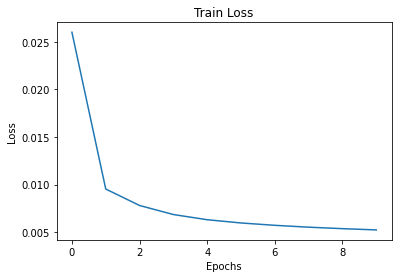

In [129]:
device = get_device()
print(device)
net.to(device)
make_dir()
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('conv_ae_cifar10_loss.png')
test_image_reconstruction(net, testloader)

In [130]:
test(net, testloader)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


0.00520171235969409

In [ ]:
#Batch of test images
dataiter = iter(testloader)

#images, labels = images.cuda(), labels.cuda() # add this line

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#images, labels = images.to(device), labels.to(device)
images, labels = dataiter.next()


#Sample outputs
output = net(images)
images = images.numpy()

batch_size = 32
output = output.view(batch_size, 3, 32, 32)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

In [89]:
def train(net, trainloader, testloader, epochs, optimizer):
    acc_loss = np.zeros(shape=(epochs, 2))
    for epoch in range(epochs):
        running_loss = 0
        for data in trainloader:
            images = data[0].to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_test_loss = test(net, testloader)
        acc_loss[epoch, 0] = running_loss
        acc_loss[epoch, 1] = running_test_loss

    # plt.plot(acc_loss[:, 0])
    # plt.show()
    print('[Epoch %d] loss: %.3f' % (epoch + 1, running_test_loss / len(testloader)))
    return acc_loss


def test(net, testloader, lossfunction):
    running_test_loss = 0
    with torch.no_grad():
        for data in testloader:
            inputs = data[0].to(device, non_blocking=True)
            outputs = net(inputs)
            loss = lossfunction(outputs, inputs)
            running_test_loss += loss

    return running_test_loss
train(net, trainloader, testloader, NUM_EPOCHS, optimizer)